In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torch

In [4]:
class CNN(nn.Module):
    def __init__(self,activation_function):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 3),#28x28 -> 26x26 (no pad)
            activation_function(),
            nn.MaxPool2d(2, stride = 2), #2x2 maxpool (divide hight and with by 2 -> 13x13)
            nn.Conv2d(6, 10, 3),#(no padding -> 11x11)
            activation_function(),
            nn.MaxPool2d(2, stride = 2)
        )
        self.linear_lay = nn.Sequential(
            nn.Linear(250, 150),# (11X11X10 (outchanels))
            activation_function(),
            nn.Linear(150, 50),
            activation_function(),
            nn.Linear(50,10)
        )
        self.images = []
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)# this flattens X before linear layer
        for val in x:
            self.images.append(val.detach().numpy())
        x = self.linear_lay(x) # bc this is our output layer. No activation here.
        
        return F.softmax(x, dim=1)

In [5]:
transform = transforms.Compose(
    [
    transforms.ToTensor()#,
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# MNIST                                           
train = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
X_train, X_val= train_test_split(
train, test_size=0.2, random_state=42)

trainLoader = torch.utils.data.DataLoader(X_train, batch_size=30,
                                          shuffle=True, num_workers=2)

validationLoader = torch.utils.data.DataLoader(X_val, batch_size=30,
                                          shuffle=True, num_workers=2)

test = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testLoader = torch.utils.data.DataLoader(test, batch_size=30,
                                         shuffle=False, num_workers=2)

In [6]:
def validate(model, modelVal, validationLoader):
    correct = 0
    total = 0
    finalLoss = 0
    batchSize = 0 
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for i, data in enumerate(validationLoader, 0):
            image, label = data
            pred = model(image)
            outputs = model(image)
            loss = criterion(outputs, label)
            finalLoss += loss       
            batchSize = i
    return finalLoss/batchSize

def test(model, loader):
    true_labels=[]
    pred_labels=[]
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            image, label = data
            pred = model(image)
            for i in range(len(data)):
                if torch.argmax(pred[i]) == label[i]:
                    correct += 1
                total += 1
    print(" predicted = ", correct/total*100, "% of total ",total)

In [7]:
import torch.optim as optim
writer = SummaryWriter()
model = CNN(nn.LeakyReLU)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)
allLabels = []
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        for label in labels:
            allLabels.append(label)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
print('Finished Training')


Finished Training


In [8]:
print(len(allLabels))

48000


In [ ]:
from sklearn.manifold import TSNE
import pandas as pd

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

from sklearn.preprocessing import StandardScaler
#df = pd.dataframe(model.images)
standardized_data = StandardScaler().fit_transform(model.images)
tsne_results = tsne.fit_transform(standardized_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 48000 samples in 3.440s...


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

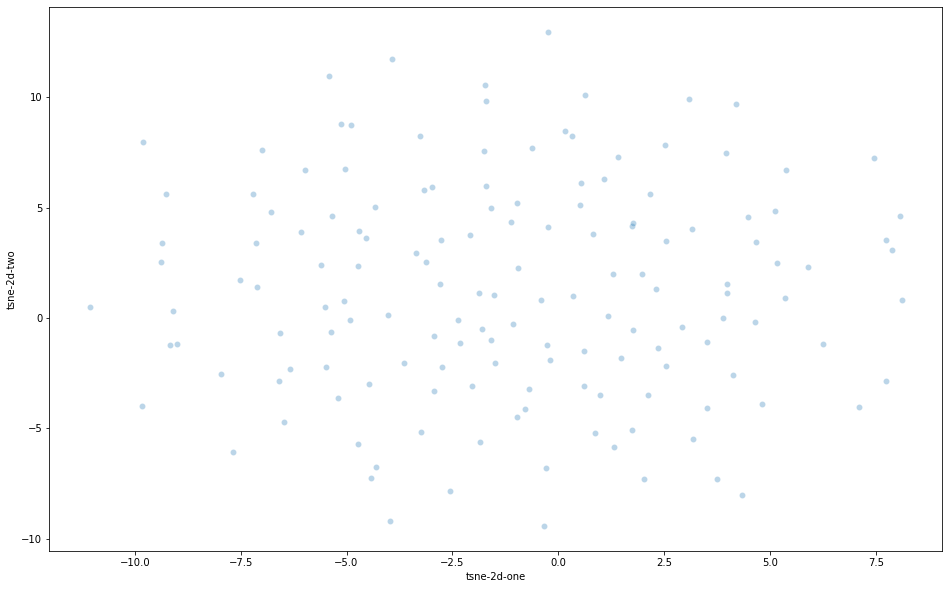

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

df_subset = {}

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [ ]:
from sklearn.preprocessing import StandardScaler
